# Abschlussprojekt: Entwicklung eines eigenen Sprachmodells

# Huggingface
https://huggingface.co/lailaterrak/genai-abschluss/tree/main

# Wanddb
https://wandb.ai/lailaterrak-hochshule-hannover/abschlussprojekt_sprachmodell/runs/if0ngkhv?nw=nwuserlailaterrak



Dieses Notebook zeigt, ein kleines, autoregressives (Decoder-only) Sprachmodell in PyTorch. Es werden folgende Schritte durchgeführt:

- Installation der benötigten Pakete
- Training eines Byte-Level BPE Tokenizers (mit Hugging Face Tokenizers)
- Erstellung eines Datasets aus einem Textfile (am Tiny Shakespeare Beispiel)
- Definition eines Transformer-basierten Sprachmodells
- Training des Modells mit Logging über Weights & Biases (wandb)


In [1]:
# Installiere nötige Pakete (Führe diesen Cell in Google Colab aus)
!pip install wandb transformers

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import wandb
from transformers import GPT2Tokenizer
import os
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True

In [3]:
if not os.path.exists("tiny_shakespeare.txt"):
    !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O tiny_shakespeare.txt

with open('tiny_shakespeare.txt', 'r') as f:
    text = f.read()

print("Dataset length:", len(text))

--2025-04-23 18:39:47--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tiny_shakespeare.txt’

tiny_shakespeare.tx 100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-04-23 18:39:47 (24.9 MB/s) - ‘tiny_shakespeare.txt’ saved [1115394/1115394]

Dataset length: 1115394


In [4]:
# Load the GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# GPT2 does not have a pad token by default: we add one.
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<pad>'})

# Tokenize the entire text (this returns a list of token IDs)
tokens = tokenizer.encode(text)
print("Tokenized dataset length:", len(tokens))

# Split tokens into training and validation sets (90/10 split)
split_idx = int(0.9 * len(tokens))
train_tokens = tokens[:split_idx]
val_tokens = tokens[split_idx:]

# Define a PyTorch Dataset for creating input and target sequences
class TextDataset(Dataset):
    def __init__(self, tokens, seq_length):
        self.tokens = tokens
        self.seq_length = seq_length

    def __len__(self):
        return len(self.tokens) - self.seq_length

    def __getitem__(self, idx):
        # For autoregressive training, the input is tokens[idx : idx+seq_length]
        # and the target is the same sequence shifted by one.
        x = torch.tensor(self.tokens[idx : idx + self.seq_length], dtype=torch.long)
        y = torch.tensor(self.tokens[idx + 1 : idx + self.seq_length + 1], dtype=torch.long)
        return x, y

# Set the sequence length (adjustable) and create datasets
seq_length = 128  # can be tuned
train_dataset = TextDataset(train_tokens, seq_length)
val_dataset = TextDataset(val_tokens, seq_length)

# Create DataLoaders
# batch_size = 64  # adjust based on your computing power
batch_size = 128  # adjust based on your computing power
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True
)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (338025 > 1024). Running this sequence through the model will result in indexing errors


Tokenized dataset length: 338025
Number of training batches: 2376
Number of validation batches: 264


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, max_seq_length, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_seq_length, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.max_seq_length = max_seq_length

        # <<< ADD: precompute a max‑size causal mask as a buffer
        mask = torch.triu(torch.full((max_seq_length, max_seq_length), float('-inf')), diagonal=1)
        self.register_buffer("mask", mask)

    def forward(self, x):
        batch_size, seq_length = x.shape
        token_embed = self.token_embedding(x)
        positions = torch.arange(seq_length, device=x.device).unsqueeze(0).expand(batch_size, seq_length)
        pos_embed = self.pos_embedding(positions)
        x = self.dropout(token_embed + pos_embed)
        x = x.transpose(0, 1)  # to (S, B, D)

        # <<< REPLACE mask creation with a slice of the precomputed buffer
        causal_mask = self.mask[:seq_length, :seq_length]
        x = self.transformer(x, mask=causal_mask)

        x = x.transpose(0, 1)  # back to (B, S, D)
        logits = self.fc_out(x)
        return logits


# Hyperparameters for the model
vocab_size = len(tokenizer)
d_model = 64
nhead = 2
num_layers = 1
# d_model = 128
# nhead = 4
# num_layers = 2
max_seq_length = seq_length

# Initialize the model
model = TransformerLanguageModel(vocab_size, d_model, nhead, num_layers, max_seq_length)

# Function to count trainable parameters (should be < 1M)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total trainable parameters:", count_parameters(model))


Total trainable parameters: 6772626


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [6]:
import wandb
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Standard cross entropy loss for language modeling
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

if hasattr(torch, "compile"):
    model = torch.compile(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)


print(f"Using device: {device}")


# Lists to store the loss history per epoch
train_loss_history = []
val_loss_history = []

# Set up GradScaler for AMP
scaler = torch.cuda.amp.GradScaler()

# Initialize wandb for logging
wandb.init(project="abschlussprojekt_sprachmodell", config={
    "epochs": 4,
    "batch_size": batch_size,
    "seq_length": seq_length,
    "learning_rate": 0.001,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
})
config = wandb.config
num_epochs = config.epochs

for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    model.train()
    total_loss = 0
    for batch, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        # Use autocast for mixed precision computations
        with torch.cuda.amp.autocast():
            logits = model(x)  # output shape: (batch_size, seq_length, vocab_size)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        # Scale the loss and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_loss)

    # Evaluate on the validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)


    print(f"Epoch {epoch}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    wandb.log({"epoch": epoch, "train_loss": avg_loss, "val_loss": avg_val_loss})


Using device: cuda


<ipython-input-6-506b996cdbed>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lailaterrak (lailaterrak-hochshule-hannover) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/4


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-6-506b996cdbed>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
W0423 18:41:23.768000 433 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode
<ipython-input-6-506b996cdbed>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/d

Epoch 1, Training Loss: 4.3408, Validation Loss: 5.1703
Epoch 2/4


<ipython-input-6-506b996cdbed>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2, Training Loss: 3.5270, Validation Loss: 5.4614
Epoch 3/4
Epoch 3, Training Loss: 3.2755, Validation Loss: 5.6882
Epoch 4/4
Epoch 4, Training Loss: 3.1063, Validation Loss: 5.8827


In [7]:
# Save the model state_dict locally
model_save_path = "model.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved to", model_save_path)

# Save the tokenizer (this creates a 'tokenizer' folder with the required files)
tokenizer.save_pretrained("tokenizer")
print("Tokenizer saved in 'tokenizer' directory.")


Model saved to model.pth
Tokenizer saved in 'tokenizer' directory.


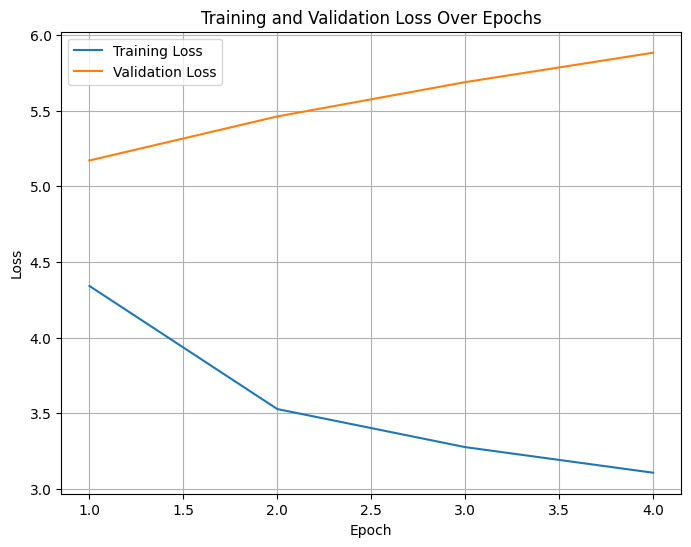

In [8]:
# Plot training and validation loss curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_history, label="Training Loss")
plt.plot(epochs, val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()